# **Reinforcement Learning: Tarea 1, Estudio comparativo de algoritmos en un problema de k-armed bandit**

## **Autores:** Ana Gil Molina, José María García Ortiz y Levi Malest Villarreal

<br>

*Description:* El experimento compara el rendimiento de algoritmos epsilon-greedy en un problema de k-armed bandit.
Se generan distintas gráficas que explicarán las ventajas y desventajas de cada algoritmo a la hora de resolver este problema.

<br>

This software is licensed under the GNU General Public License v3.0 (GPL-3.0),
with the additional restriction that it may not be used for commercial purposes.

For more details about GPL-3.0: https://www.gnu.org/licenses/gpl-3.0.html



## **Preparación del entorno**


In [1]:
#@title Copiar el repositorio ``JMGO-coding/k_brazos_GGM``.

!git clone https://github.com/JMGO-coding/k_brazos_GGM.git
!cd k_brazos_GGM/

Cloning into 'k_brazos_GGM'...
remote: Enumerating objects: 308, done.
remote: Counting objects: 100% (153/153), done.
remote: Compressing objects: 100% (152/152), done.
remote: Total 308 (delta 88), reused 1 (delta 1), pack-reused 155 (from 1)
Receiving objects: 100% (308/308), 909.19 KiB | 6.10 MiB/s, done.
Resolving deltas: 100% (144/144), done.


In [2]:
#@title Importamos todas las clases y funciones

import sys

# Añadir los directorio fuentes al path de Python
sys.path.append('/content/k_brazos_GGM')
sys.path.append('/content/k_brazos_GGM/src')



# Verificar que se han añadido correctamente
print(sys.path)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List

#from src.algorithms import Algorithm, EpsilonGreedy
#from src.arms import ArmNormal, Bandit
#from src.plotting import plot_average_rewards, plot_optimal_selections, plot_arm_statistics, plot_regret


from algorithms import Algorithm, EpsilonGreedy
from arms import ArmNormal, Bandit
from plotting import plot_average_rewards, plot_optimal_selections, plot_arm_statistics, plot_regret

['/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/usr/local/lib/python3.11/dist-packages/setuptools/_vendor', '/root/.ipython', '/content/k_brazos_GGM', '/content/k_brazos_GGM/src']


## **Experimento**

Cada algoritmo se ejecuta en un problema de k-armed bandit durante un número de pasos de tiempo y ejecuciones determinado.
Se comparan los resultados de los algoritmos en términos de recompensa promedio.

Por ejemplo. Dado un bandido de k-brazos, se ejecutan dos algoritmos epsilon-greedy con diferentes valores de epsilon. Se estudia la evolución de cada política  en un número de pasos, por ejemplo, mil pasos. Entonces se repite el experimento un número de veces, por ejemplo, 500 veces. Es decir, se ejecutan 500 veces la evolución de cada algoritmo en 1000 pasos. Para cada paso calculamos el promedio de las recoponensas obtenidas en esas 500 veces.

In [3]:
def run_experiment(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):

    optimal_arm = bandit.optimal_arm  # Necesario para calcular el porcentaje de selecciones óptimas.

    rewards = np.zeros((len(algorithms), steps)) # Matriz para almacenar las recompensas promedio.

    optimal_selections = np.zeros((len(algorithms), steps))  # Matriz para almacenar el porcentaje de selecciones óptimas.

    np.random.seed(seed)  # Asegurar reproducibilidad de resultados.

    for run in range(runs):
        current_bandit = Bandit(arms=bandit.arms)

        for algo in algorithms:
            algo.reset() # Reiniciar los valores de los algoritmos.

        total_rewards_per_algo = np.zeros(len(algorithms)) # Acumulador de recompensas por algoritmo. Necesario para calcular el promedio.

        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm() # Seleccionar un brazo según la política del algoritmo.
                reward = current_bandit.pull_arm(chosen_arm) # Obtener la recompensa del brazo seleccionado.
                algo.update(chosen_arm, reward) # Actualizar el valor estimado del brazo seleccionado.

                rewards[idx, step] += reward # Acumular la recompensa obtenida en la matriz rewards para el algoritmo idx en el paso step.
                total_rewards_per_algo[idx] += reward # Acumular la recompensa obtenida en total_rewards_per_algo para el algoritmo idx.

                #TODO: modificar optimal_selections cuando el brazo elegido se corresponda con el brazo óptimo optimal_arm


    rewards /= runs

    # TODO: calcular el porcentaje de selecciones óptimas y almacenar en optimal_selections

    return rewards, optimal_selections


In [4]:
def run_experiment(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):
    """
    Ejecuta experimentos comparativos entre diferentes algoritmos.

    :param bandit: Instancia de Bandit configurada para el experimento.
    :param algorithms: Lista de instancias de algoritmos a comparar.
    :param steps: Número de pasos de tiempo por ejecución.
    :param runs: Número de ejecuciones independientes.
    :return: Tuple de tres elementos: recompensas promedio, porcentaje de selecciones óptimas, y estadísticas de brazos.
    :rtype: Tuple of (np.ndarray, np.ndarray, list)
    """

    k = bandit.k
    optimal_arm = bandit.optimal_arm

    # Inicializar matrices para recompensas y selecciones óptimas
    rewards = np.zeros((len(algorithms), steps))
    optimal_selections = np.zeros((len(algorithms), steps))

    # Inicializar el regret global acumulado por cada algoritmo
    global_cumulative_regret_per_algo = np.zeros((len(algorithms),steps))

    for run in range(runs):
        # Crear una nueva instancia del bandit para cada ejecución
        current_bandit = Bandit(arms=bandit.arms)

        # Obtener la recompensa esperada óptima
        q_max = current_bandit.get_expected_value(current_bandit.optimal_arm)

        for algo in algorithms:
            algo.reset()

        # Inicializar recompensas acumuladas por algoritmo para esta ejecución
        total_rewards_per_algo = np.zeros(len(algorithms))  # Para análisis por rechazo

        # Inicializar recompensas acumuladas por algoritmo para esta ejecución
        # cumulative_rewards_per_algo = np.zeros(len(algorithms))

        num_choices_list = [[0 for _ in range(len(current_bandit.arms))] for _ in algorithms]   # para almacenar un conteo de las selecciones de cada brazo del bandido para cada algoritmo

        rewards_per_arm = np.zeros((len(algorithms), len(current_bandit.arms)))    # para almacenar las recompensas por cada brazo

        # Ejecutar cada algoritmo
        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm()
                reward = current_bandit.pull_arm(chosen_arm)
                algo.update(chosen_arm, reward)

                num_choices_list[idx][chosen_arm] += 1   # Actualizamos el conteo del brazo seleccionado en la estapa correspondiente del algoritmo ``algo``

                rewards[idx, step] += reward
                total_rewards_per_algo[idx] += reward

                rewards_per_arm[idx][chosen_arm] += reward

                global_cumulative_regret_per_algo[idx, step] = q_max*step - total_rewards_per_algo[idx]    # Actualziamos el regret acumulado en cada paso de decisión para cada algoritmo

                if chosen_arm == optimal_arm:
                    optimal_selections[idx, step] += 1

    # Promediar las recompensas y el regret sobre todas las ejecuciones
    rewards /= runs
    optimal_selections = (optimal_selections / runs) * 100
    proportional_cumulative_regret_per_algo = global_cumulative_regret_per_algo.copy()
    proportional_cumulative_regret_per_algo /= runs
    rewards_per_arm /= runs

    return rewards, optimal_selections, num_choices_list, proportional_cumulative_regret_per_algo, rewards_per_arm

### Ejecución del experimento

Se realiza el experimento usando 10 brazos, cada uno de acuerdo a una distribución gaussina con desviación 1. Se realizan 500 ejecuciones de 1000 pasos cada una. Se contrastan 3 algoritmos epsilon greedy para valores epsilon: 0.0, 0.01, y 0.1.

In [5]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10        # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500    # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmNormal.generate_arms(k))    # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 3 algoritmos epsilon-greedy con diferentes valores de epsilon.
algorithms = [EpsilonGreedy(k=k, epsilon=0), EpsilonGreedy(k=k, epsilon=0.01), EpsilonGreedy(k=k, epsilon=0.1)]

# Extras
optimal_arms_list = [optimal_arm for _ in range(len(algorithms))]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, num_choices_list, proportional_cumulative_regret_per_algo, rewards_per_arm = run_experiment(bandit, algorithms, steps, runs)

# Estadísticas de cada brazo
arm_stats = [{arm: {"media": arm.mu, "std": arm.sigma} for arm in bandit.arms} for _ in range(len(algorithms))]

# Agregar la recompensa por brazo de cada algoritmo en el diccionario correspondiente
for algo_idx in range(len(algorithms)):  # Para cada algoritmo
    for arm_idx, arm in enumerate(bandit.arms):  # Para cada brazo del bandido
        arm_stats[algo_idx][arm]["reward"] = rewards_per_arm[algo_idx][arm_idx]  # Añadir el reward


Bandit with 10 arms: ArmNormal(mu=1.52, sigma=1.0), ArmNormal(mu=2.4, sigma=1.0), ArmNormal(mu=1.19, sigma=1.0), ArmNormal(mu=4.37, sigma=1.0), ArmNormal(mu=6.39, sigma=1.0), ArmNormal(mu=7.59, sigma=1.0), ArmNormal(mu=8.8, sigma=1.0), ArmNormal(mu=9.56, sigma=1.0), ArmNormal(mu=6.41, sigma=1.0), ArmNormal(mu=7.37, sigma=1.0)
Optimal arm: 8 with expected reward=9.56


### Visualización de los resultados

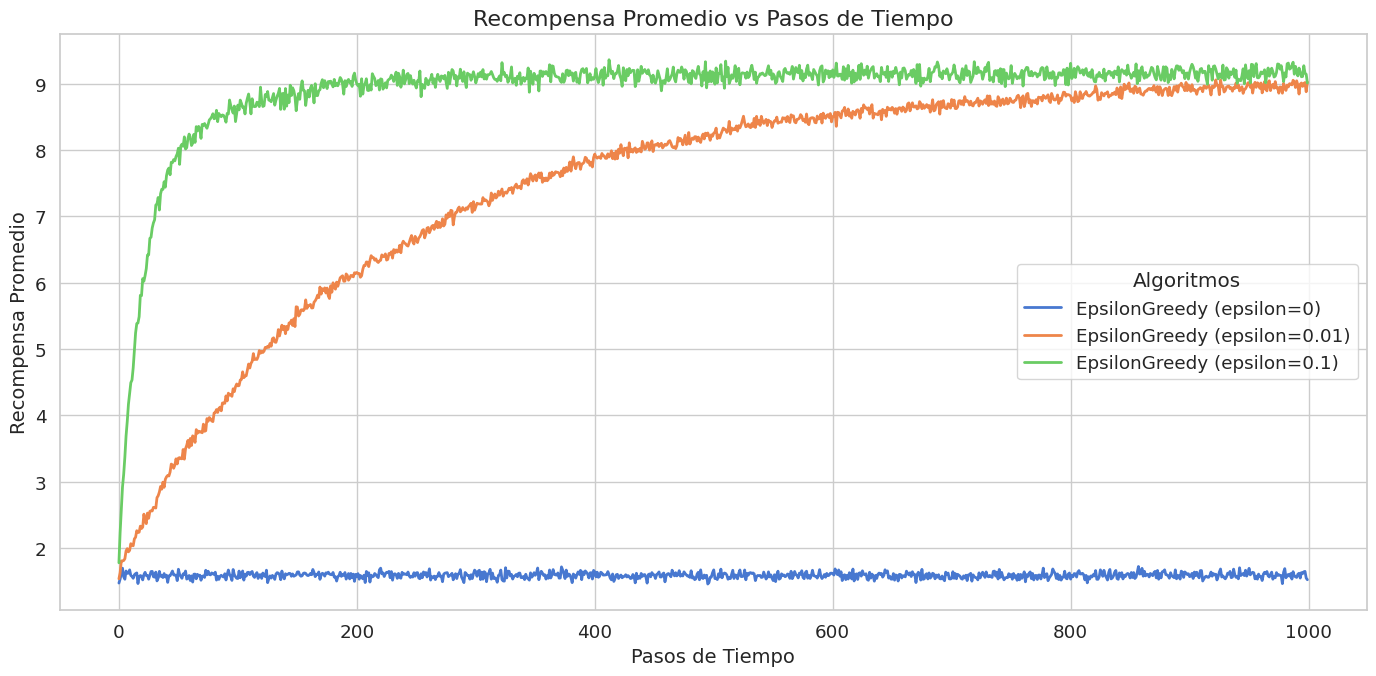

In [6]:
plot_average_rewards(steps, rewards, algorithms)

### Análisis detallado de la imagen

La imagen muestra un gráfico de líneas titulado **"Recompensa Promedio vs Pasos de Tiempo"**, donde se analiza el desempeño de diferentes estrategias del algoritmo **ε-Greedy** en un entorno de multi-armed bandit. En el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra la **recompensa promedio** obtenida por cada algoritmo.


1. **Tres líneas de colores distintos representan diferentes valores de ε en el algoritmo ε-Greedy:**
   - **Azul (ε = 0):** Representa una estrategia completamente **explotadora**, es decir, que siempre elige la acción que ha dado la mejor recompensa hasta ahora sin explorar nuevas opciones.
   - **Naranja (ε = 0.01):** Representa una estrategia con una pequeña probabilidad del 1% de elegir una acción aleatoria (exploración).
   - **Verde (ε = 0.1):** Representa una estrategia con un 10% de probabilidad de explorar acciones aleatorias.

2. **Crecimiento de la recompensa promedio:**
   - La línea **verde (ε=0.1)** alcanza rápidamente una recompensa promedio alta, lo que indica que la estrategia con mayor exploración aprende más rápido qué brazos del bandit son óptimos.
   - La línea **naranja (ε=0.01)** también muestra un crecimiento, pero más lento en comparación con ε=0.1.
   - La línea **azul (ε=0)** se mantiene en un nivel bajo de recompensa, lo que sugiere que no logra encontrar el mejor brazo porque no explora nuevas opciones.

---





## **Conclusiones**

Hemos estudiado un  **experimento de toma de decisiones secuenciales**, modelado con un **Multi-Armed Bandit (MAB)**. Este problema es fundamental en el aprendizaje por refuerzo y la teoría de decisiones. La idea principal es que un agente debe aprender cuál es la mejor acción (brazo del bandit) a partir de la experiencia acumulada. Para este estudio nos hemos centrado solo en el estudio del algoritmo epsilon-greedy, llegando a las siguientes conclusiones a partir de los resultados obtenidos y la gráfica generada:

#### **1. Exploración vs Explotación**
El algoritmo **ε-Greedy** equilibra la exploración y la explotación:
- **Explotación (ε=0)**: Siempre elige la mejor opción conocida, pero si inicialmente se selecciona un brazo subóptimo, nunca descubrirá otras opciones más rentables.
- **Exploración (ε>0)**: Introduce aleatoriedad en la selección de acciones para descubrir nuevas opciones potencialmente mejores.

El gráfico confirma este comportamiento:
- **ε=0.1 (verde)** obtiene la mejor recompensa promedio a lo largo del tiempo porque explora lo suficiente como para encontrar rápidamente el mejor brazo.
- **ε=0.01 (naranja)** explora menos, por lo que tarda más en converger a una recompensa alta.
- **ε=0 (azul)** no explora en absoluto y queda atrapado en una recompensa subóptima.

#### **2. Convergencia de los algoritmos**
Los algoritmos con mayor exploración (ε=0.1) alcanzan una recompensa alta más rápido. Esto se debe a que:
- Al principio, el algoritmo **no tiene información suficiente** sobre cuál es el mejor brazo.
- Con el tiempo, al realizar exploraciones, descubre cuál es el mejor brazo y empieza a explotarlo más.
- Un **balance entre exploración y explotación** es clave para maximizar la recompensa a largo plazo.


#### **3. Aplicaciones y conclusiones**
- En problemas de toma de decisiones **(ejemplo: recomendaciones, optimización de anuncios, medicina personalizada)**, una estrategia de exploración moderada como **ε=0.1** es más efectiva para encontrar la mejor opción rápidamente.
- **La falta de exploración (ε=0)** lleva a un desempeño deficiente, ya que el agente puede quedarse atrapado en una elección subóptima.

En conclusión, **el gráfico muestra cómo un nivel adecuado de exploración mejora significativamente el rendimiento del algoritmo en un entorno de aprendizaje por refuerzo**. 🚀

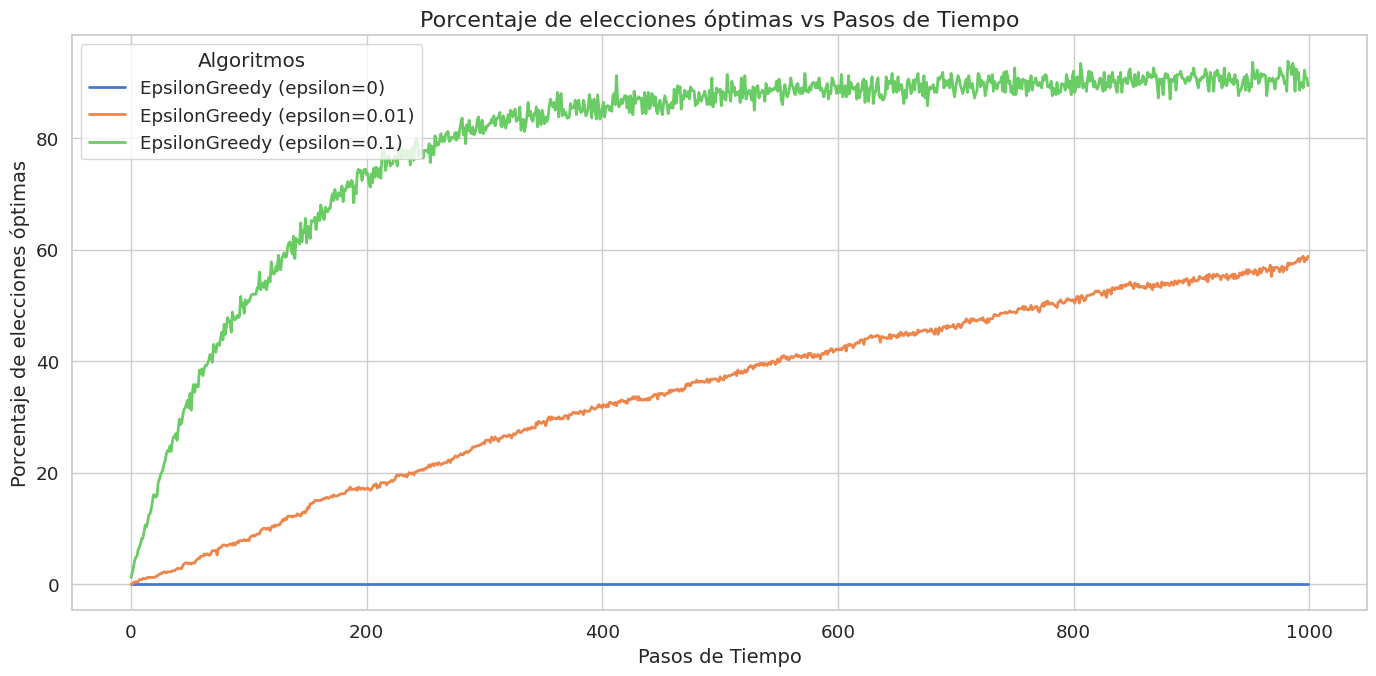

In [7]:
plot_optimal_selections(steps, optimal_selections, algorithms)

In [8]:
data_list = [[arm_stats[j][key]["reward"] for key in arm_stats[j].keys()] for j in range(len(arm_stats))]

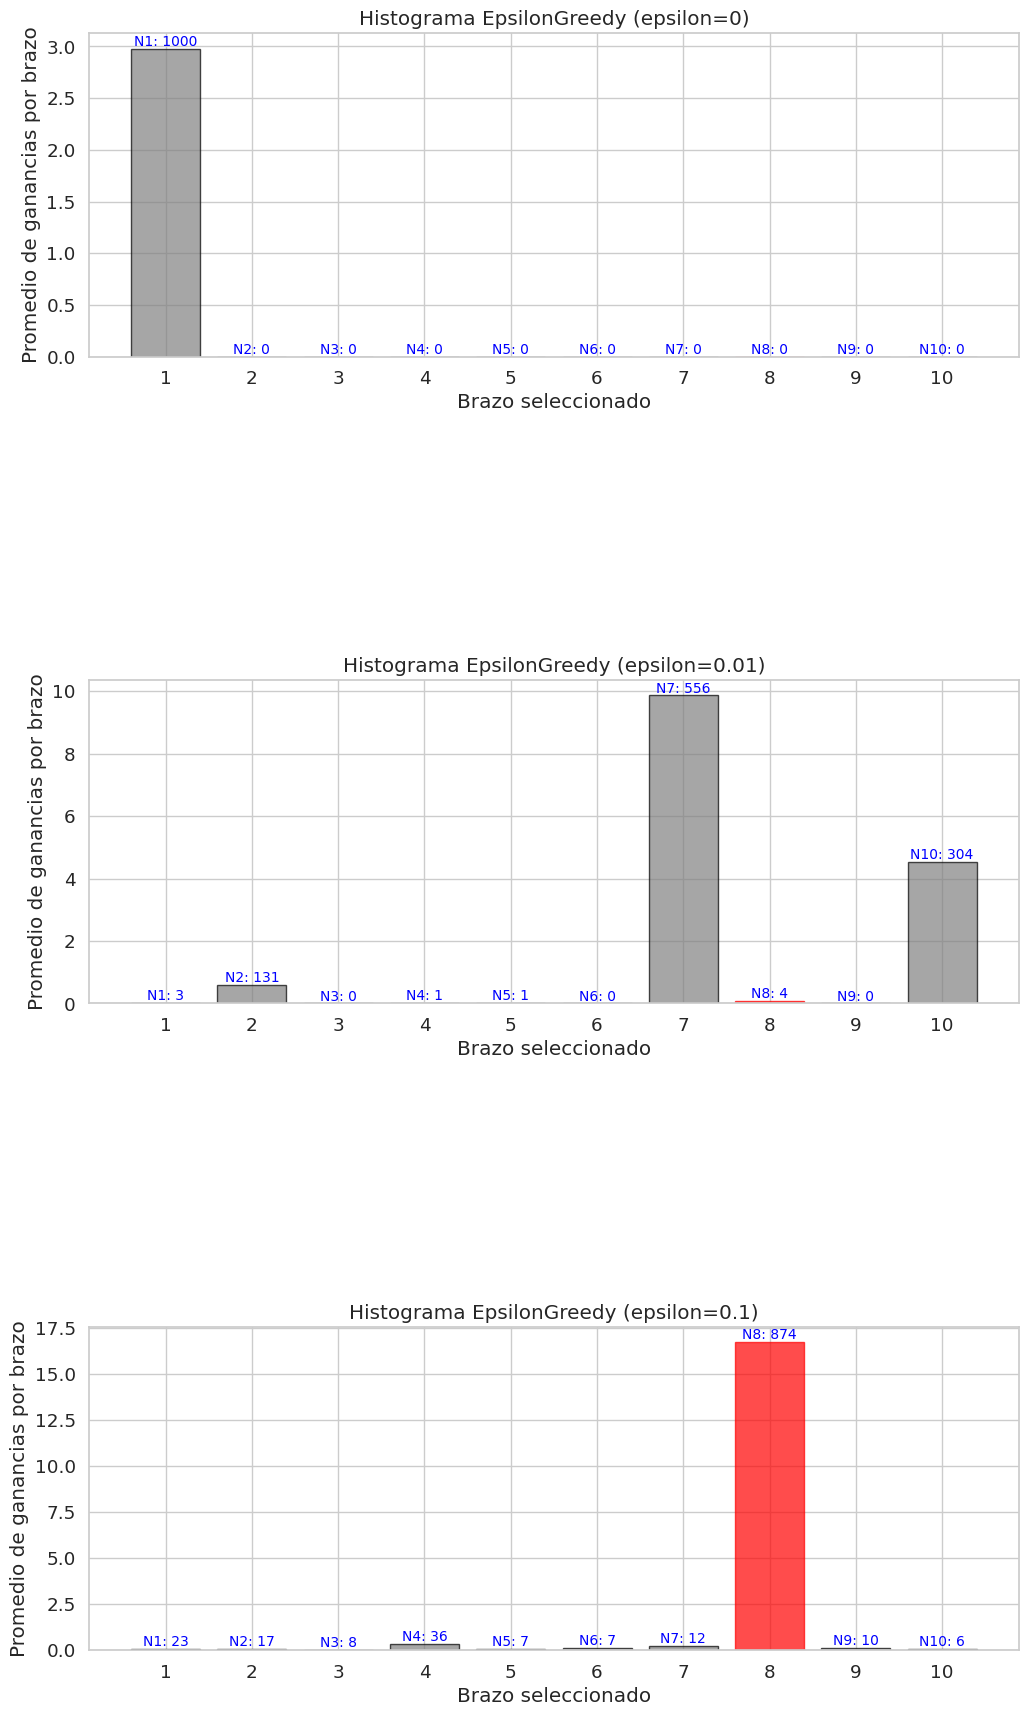

In [9]:
plot_arm_statistics(arm_stats, algorithms, optimal_arms_list, num_choices_list)

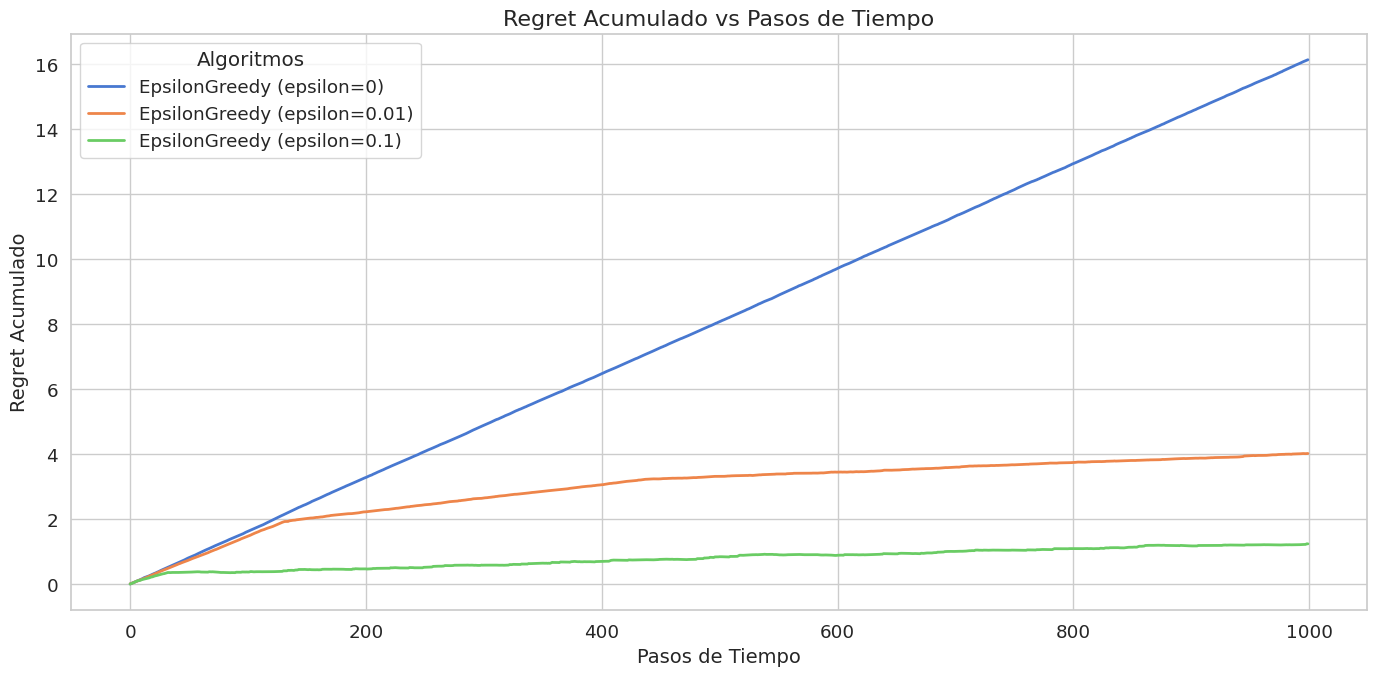

In [11]:
plot_regret(steps, regret_accumulated=proportional_cumulative_regret_per_algo, algorithms = algorithms)